# Step-Index Fibre

Refractive index:
$$
n(r\leq a) = n_\mathrm{core}\\
n(r > a) = n_\mathrm{clad}\\
$$

and boundary conditions
$$
E(r^{(-)}=a) = E(r^{(+)}=a)\\
E^\prime(r^{(-)}=a) = E^\prime(r^{(+)}=a)
$$
where $r^{(-)}$ and $r^{(+)}$ refer to the radial co-ordinate when approacing from $-\infty$ and $+\infty$ respectively.

The solution is
$$
E(r,\phi,z,t) = \sum_{lm} \psi_{lm}(r) e^{il\phi} e^{i\beta_{lm} z} e^{-i\omega t} \left|a_{lm}\right|e^{i\theta_{lm}}
$$

with
$$
\psi_{lm}(r) = \begin{cases}
A_{lm} J_l\left(u_{lm}\frac{r}{a}\right) & r\leq a\\
A_{lm} \frac{J_l\left(u_{lm}\right)}{K_l\left(w_{lm}\right)} K_l\left(w_{lm}\frac{r}{a}\right) & r\geq a
\end{cases}
$$

where 
$$
u_{lm} = a\sqrt{n_\mathrm{core}^2k_0^2 - \beta_{lm}^2}\\
w_{lm} = a\sqrt{\beta_{lm}^2 - n_\mathrm{clad}^2k_0^2}
$$ 
where $J_l$ is the Bessel function of the _1<sup>st</sup>_ kind, and $K_l$ is the modified Bessel function of the _2<sup>nd</sup>_ kind.

For the mode to be propagating, $u_{lm}$ and $w_{lm}$ must be real, thus
$$
n_\mathrm{clad} \leq \beta_{lm}/k_0 \leq n_\mathrm{core}
$$ 

Thus $u_{lm}^\text{max} = V$.

**Note that for $l=0$, there is also a solution for the first root larger than V**

The above expressions ensure continuity across the boundary, but it is also necessary to enforce a continuous gradient, yielding the following expression.

$$
u_{lm} \frac{
    J_{l\pm 1}\left(u_{lm}\right)
}{
    J_{l}\left(u_{lm}\right)
} = \pm w_{lm} \frac{
    K_{l\pm 1}\left(w_{lm}\right)
}{
    K_{l}\left(w_{lm}\right)
}
$$
Note that $u_{lm}$ does not correspond to the zeros of the Bessel function.

This transcendental equation is easier to solve with the following expressions for the normalized frequency, $V$, and normalized propagation constants, $b_{lm}$ respectively:
$$
V = \sqrt{u_{lm}^2 + w_{lm}^2}
= a k_0 \sqrt{n_\mathrm{core}^2 - n_\mathrm{clad}^2}
= a k_0 \mathrm{NA}
= a k_0 n_\mathrm{core} \sqrt{2\Delta}\\

b_{lm} = 1 - \left(\frac{u_{lm}}{w_{lm}}\right)^2
= \left(\frac{w_{lm}}{V}\right)^2
= \frac{\left(\frac{\beta_{lm}}{k_0}\right)^2 - n_\mathrm{clad}^2}{(n_\mathrm{core}^2 - n_\mathrm{clad}^2)}
= \frac{\bar{n}^2 - n_\mathrm{clad}^2}{\mathrm{NA}^2}
$$

leading to the substitutions 
$$
w_{lm} = V \sqrt{b_{lm}},\quad
u_{lm} = V \sqrt{1 - b_{lm}}.
$$ 
Note the subscripts $lm$ are often dropped from the expressions for $u$, $w$, $b$ and $\beta$, although they are mode dependent; $V$, the normalized frequency, however is mode independent and is a parameter of the fibre itself.

The number of modes that a fibre can support can be approximated by the expression
$$
N_m \approx \frac{V^2}{2}.
$$

The exact number of modes can be found by solving the transcendtal boundary condition equation above, which is detailed in the code below.

In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy import special, optimize
from matplotlib import pyplot as plt

# # Smallest difference from 1
eps = np.spacing(1)

PI = np.pi
TAU = 2*PI

## Functions

In [2]:
# Refractive index of bulk fused silica (SiO2) - Malitson (1965)
def ref_index_fused_silica(l_um: NDArray) -> NDArray:
    return np.sqrt(
        1
        + 0.6961663 / (1 - (0.0684043 / l_um) ** 2)
        + 0.4079426 / (1 - (0.1162414 / l_um) ** 2)
        + 0.8974794 / (1 - (9.896161 / l_um) ** 2)
    )

# Calculate the maximum number of modes (propagation constant must be real)
#  u_max = V
def roots(V: float, l: int = 0, Nm: int = 10):
    Nm = max(Nm, 1)
    root_lm = special.jn_zeros(l, Nm)
    # if l==0 and V<=root_lm[0]:
        # return root_lm[:1]
    while root_lm[-1] < V:
        Nm *= 2
        root_lm = special.jn_zeros(l, Nm)
    # Number of solutions.
    # For l=0, include the first root larger than V
    Nm = sum(root_lm < V).item() + (l==0)
    return (root_lm[:Nm], Nm)

## Define Fibre Parameters

In [3]:
l0 = 633e-3 # Wavelength [um]
k0 = TAU/l0
d = 10 # Core diameter [um]
a = d/2 # Fibre radius [um]
NA = 0.1 # Numerical aperture

n_clad = ref_index_fused_silica(l0) # Ref. index of cladding
n_core = np.sqrt(NA**2 + n_clad**2) # Ref. index of core

# Normalized frequency
V = a * k0 * NA

## Find number of modes

For a given $l$, find number of roots, $J_l(\rho_{lm})=0$ such that $\rho_{lm} \leq V$.

For $l=0$, there are 2 modes per root ()
For $l\geq1$, there are 4 modes per root ($\pm l$ and two polarizations).

In [4]:
u_lm = []
N_lm = []
l = 0
while True:
    u, N = roots(V, l)
    if N == 0:
        break
    u_lm.append(u)
    N_lm.append(N)
    l += 1

### Check Modes

Output the zeros of the Bessel functions to make sure we haven't missed any. The first non-guided root for each l, as well as the first non-guided l is displayed to check it is larger than V.

In [5]:
print(f"V = {V:.6f}")
Nl = len(N_lm)
for l in range(Nl+1):
    N = N_lm[l]+1 if l<Nl else 1
    print(f"{l = }:", special.jn_zeros(l, N))

V = 4.963022
l = 0: [2.40482556 5.52007811 8.65372791]
l = 1: [3.83170597 7.01558667]
l = 2: [5.1356223]


## Display Results

In [6]:
print("Valid LP modes:")
_ = [print(f"LP_{l}{m}") for l, N_l in enumerate(N_lm) for m in range(N_l)]
print(f"V = {V:.3f}")
print(f"Approximate number of modes (V^2/2): {V**2/2:.2f}")

# Two polarizations for l=0, four for l>0 
print("\nTotal number of modes:", 2*N_lm[0] + 4*sum(N_lm[1:]))

Valid LP modes:
LP_00
LP_01
LP_10
V = 4.963
Approximate number of modes (V^2/2): 12.32

Total number of modes: 8


## Find Propagation Constants

In [9]:
U = lambda V, b: V * np.sqrt(1 - b)
W = lambda V, b: V * np.sqrt(b)
LHS = lambda U, l: U * special.jn(l + 1, U) / special.jn(l, U)
RHS = lambda W, l: W * special.kn(l + 1, W) / special.kn(l, W)

# Returns the normalized propagation constants for each mode, b_lm
def get_mode_parameters(
    V: float, Nm: int, roots_m: NDArray, l: int = 0, eps: float = eps
):
    if (not roots_m.size) or any(roots_m < 0):
        roots_m = special.jn_zeros(l, Nm)
    lhs = lambda b: LHS(U(V, b), l)
    rhs = lambda b: RHS(W(V, b), l)

    # Set up transcendental equation
    f = lambda b: lhs(b) - rhs(b)

    # Loop over roots of Bessel function to find crossing between zeros
    b_lm = []
    # b = np.hstack((1, 1 - (u_lm / V) ** 2, 0))
    b = np.hstack((1, bU(V, roots_m), 0))
    for bp in pairwise(b):
        try:
            with np.errstate(divide="ignore"):
                sol = optimize.root_scalar(f, bracket=[bp[0] - eps, bp[1] + eps])
            # sol = optimize.root_scalar(f, x0=np.mean(bp), method="newton")
            b_lm.append(sol.root)
        except:
            ...

    return np.array(b_lm)

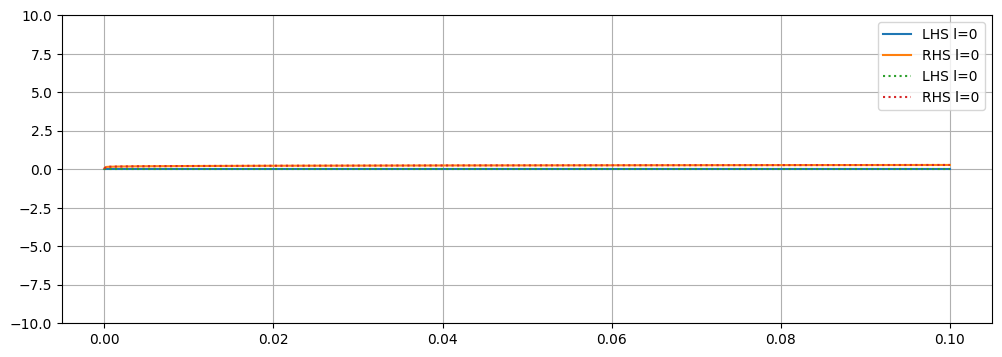

In [41]:
l = 0
# V = a * k0 * NA
# V = special.jn_zeros(l, 10)[0]
V = 0.1
fig, ax = plt.subplots(figsize=(12, 4))
b = np.linspace(eps, .1, 500)
ax.plot(b, LHS(U(V, b), l), label=f"LHS {l=}")
ax.plot(b, RHS(W(V, b), l), label=f"RHS {l=}")
ax.plot(b, LHS(U(V, b), 0), ":", label="LHS l=0")
ax.plot(b, RHS(W(V, b), 0), ":", label="RHS l=0")
ax.grid()
ax.set_ylim([-10, 10])
ax.legend()
plt.show()